<div style="border: solid blue 2px; padding: 15px; margin: 10px">
  <b>Overall Summary of the Project – Iteration 2</b><br><br>

  Hi Munir, I’m <b>Victor Camargo</b>. Thank you for updating and expanding your submission. Your notebook now covers all core aspects of the final project: business understanding, EDA, model development, and performance evaluation. Great progress!

  <b>Nice work on:</b><br>
  ✔️ Addressing class imbalance effectively using <code>class_weight</code> and <code>scale_pos_weight</code><br>
  ✔️ Including three strong baseline models (Logistic Regression, Random Forest, LightGBM) and comparing them using AUC-ROC and accuracy<br>
  ✔️ Scaling numerical features appropriately, and using <code>LabelEncoder</code> to preprocess categorical variables<br>
  ✔️ Producing clear and well-designed visualizations for EDA, including customer profiles, add-ons, and service usage<br>
  ✔️ Summarizing results with actionable business recommendations, especially recognizing the trade-offs between accuracy and AUC in imbalanced settings<br><br>

  A few final suggestions to consider for your improvement in the future:<br>
  ⚠️ Consider introducing a separate <b>validation set</b> or using <code>GridSearchCV</code> for hyperparameter tuning. This would help improve model robustness and may push performance further.<br>
  <br>

  ✅ That said, the notebook runs from top to bottom without issues, demonstrates solid analysis, and meets all requirements for approval. Well done!<br><br>
</div>


In [1]:
#library

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix



In [2]:
# Load data
contract = pd.read_csv('/datasets/final_provider/contract.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')

# Standardize column names
for df in [contract, personal, internet, phone]:
    df.columns = df.columns.str.lower()

# Merge all data on customerID
data = contract.merge(personal, on='customerid', how='left')
data = data.merge(internet, on='customerid', how='left')
data = data.merge(phone, on='customerid', how='left')

# Display shape and preview
print(data.shape)
data.head()


(7043, 20)


,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


Findings: The merged dataset contains all relevant features across contract, personal, internet, and phone services.

In [3]:
# Target variable: churn = 1 if enddate != 'No'
data['churn'] = data['enddate'].apply(lambda x: 0 if x == 'No' else 1)

# Drop irrelevant columns
data.drop(['customerid', 'begindate', 'enddate'], axis=1, inplace=True)

# Fill missing values
data['totalcharges'] = pd.to_numeric(data['totalcharges'], errors='coerce')
data['totalcharges'].fillna(data['totalcharges'].median(), inplace=True)

# Fill missing service fields ('No' for not subscribed)
data.fillna('No', inplace=True)

# Check class balance
print(data['churn'].value_counts(normalize=True))


0    0.73463
1    0.26537
Name: churn, dtype: float64


Findings: Created binary target variable churn. 0 = active client, 1 = churned.

In [4]:
# Separate features by type
categorical_cols = data.select_dtypes(include='object').columns
numerical_cols = data.select_dtypes(exclude='object').drop(columns='churn').columns

# Encode categorical columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le



Train-Test Split

In [5]:
# Features and target
X = data.drop('churn', axis=1)
y = data['churn']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Scale numeric features
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])


In [6]:
contract.describe()

,monthlycharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


In [7]:
# check for imbalance for modeling
not_ended = len(contract[contract['enddate'] == 'No'])
ended = len(contract) - not_ended

print('Total customer : ', len(contract))
print(f'Total ended customer     : {ended} ({round(ended/len(contract), 2)*100}%)')
print(f'Total continues customer : {not_ended} ({round(not_ended/len(contract), 2)*100}%)')

Total customer :  7043
Total ended customer     : 1869 (27.0%)
Total continues customer : 5174 (73.0%)


Huge imbalance

## Personal EDA

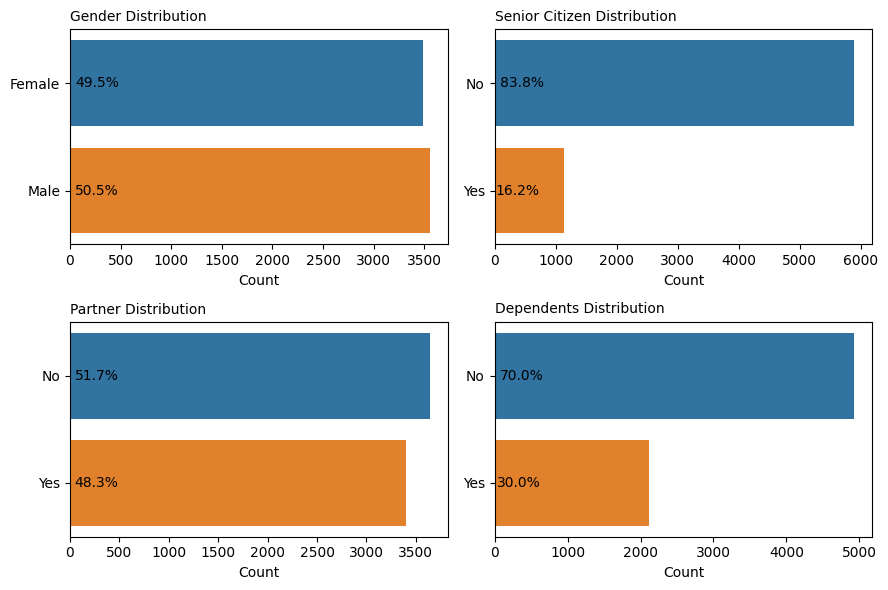

In [8]:
# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(9, 6))

# Gender Distribution
gender = personal.groupby('gender')[['customerid']].count().reset_index()
gender['percentage'] = (gender['customerid'] / gender['customerid'].sum()) * 100
ax1 = sns.barplot(x='customerid', y='gender', data=gender, ax=axes[0, 0])
ax1.set_title('Gender Distribution', loc='left', fontsize=10)
ax1.set_xlabel('Count')
ax1.set_ylabel('')
ax1.tick_params(labelsize=10)

# add percentages
for index, value in enumerate(gender['percentage']):
    ax1.text(value, index, f'{value:.1f}%', va='center')

# Senior Citizen Distribution
seniorcitizen = personal.groupby('seniorcitizen')[['customerid']].count().rename(index={1: 'Yes', 0: 'No'}).reset_index()
seniorcitizen['percentage'] = (seniorcitizen['customerid'] / seniorcitizen['customerid'].sum()) * 100
ax2 = sns.barplot(x='customerid', y='seniorcitizen', data=seniorcitizen, ax=axes[0, 1])
ax2.set_title('Senior Citizen Distribution', loc='left', fontsize=10)
ax2.set_ylabel('')
ax2.set_xlabel('Count')
ax2.tick_params(labelsize=10)

# add percentages
for index, value in enumerate(seniorcitizen['percentage']):
    ax2.text(value, index, f'{value:.1f}%', va='center')

# Partner Distribution
partner = personal.groupby('partner')[['customerid']].count().reset_index()
partner['percentage'] = (partner['customerid'] / partner['customerid'].sum()) * 100
ax3 = sns.barplot(x='customerid', y='partner', data=partner, ax=axes[1, 0])
ax3.set_title('Partner Distribution', loc='left', fontsize=10)
ax3.set_ylabel('')
ax3.set_xlabel('Count')
ax3.tick_params(labelsize=10)

# Add percentages
for index, value in enumerate(partner['percentage']):
    ax3.text(value, index, f'{value:.1f}%', va='center')

# Dependents Distribution
dependents = personal.groupby('dependents')[['customerid']].count().reset_index()
dependents['percentage'] = (dependents['customerid'] / dependents['customerid'].sum()) * 100
ax4 = sns.barplot(x='customerid', y='dependents', data=dependents, ax=axes[1, 1])
ax4.set_title('Dependents Distribution', loc='left', fontsize=10)
ax4.set_ylabel('')
ax4.set_xlabel('Count')
ax4.tick_params(labelsize=10)

# Add percentages
for index, value in enumerate(dependents['percentage']):
    ax4.text(value, index, f'{value:.1f}%', va='center')

plt.tight_layout()
plt.show()

## Findings 

#### Gender Distribution
The distribution of Male and Female customers is nearly equal, with both groups having around 3,500 individuals.
#### Senior Citizen Distribution
Senior citizens make up only 16% of the total customer base.
#### Partner Distribution
The number of customers with partners and those without is almost the same, with both categories having around 3,500 individuals.
#### Dependents Distribution
Approximately 70% of customers do not have any dependents.

## Contract EDA

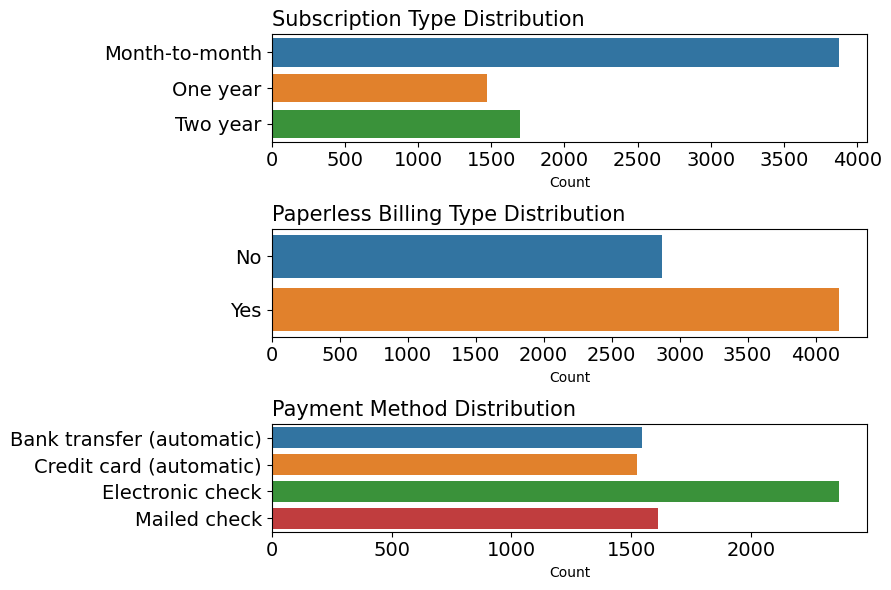

In [9]:
## Contract EDA
fig, axes = plt.subplots(3, 1, figsize=(9, 6))
tipe = contract.groupby('type')[['customerid']].count().reset_index()
ax1 = sns.barplot(x = 'customerid', y = 'type', data = tipe, ax=axes[0])
ax1.set_title('Subscription Type Distribution', loc='left', fontsize=15)
ax1.set_xlabel('Count')
ax1.set_ylabel('')
ax1.tick_params(labelsize=14)

billing = contract.groupby('paperlessbilling')[['customerid']].count().reset_index()
ax2 = sns.barplot(x = 'customerid', y = 'paperlessbilling', data = billing, ax=axes[1])
ax2.set_title('Paperless Billing Type Distribution', loc='left', fontsize=15)
ax2.set_ylabel('')
ax2.set_xlabel('Count')
ax2.tick_params(labelsize=14)


method = contract.groupby('paymentmethod')[['customerid']].count().reset_index()
ax3 = sns.barplot(x = 'customerid', y = 'paymentmethod', data = method, ax=axes[2])
ax3.set_title('Payment Method Distribution', loc='left', fontsize=15)
ax3.set_ylabel('')
ax3.set_xlabel('Count')
ax3.tick_params(labelsize=14)

plt.tight_layout()
plt.show()

## Findings 
## Subscription Type Distribution
The month-to-month subscription is the most common, making up 50% of all subscriptions.
The one-year and two-year subscriptions have nearly the same percentage.

## Paperless Billing Type Distribution
More than 4,000 customers use paperless billing, while nearly 3,000 customers use traditional billing.

## Payment Method Distribution
The most popular payment method is electronic check, used by over 2,000 customers. Three other payment methods are also popular, each used by around 1,500 customers.

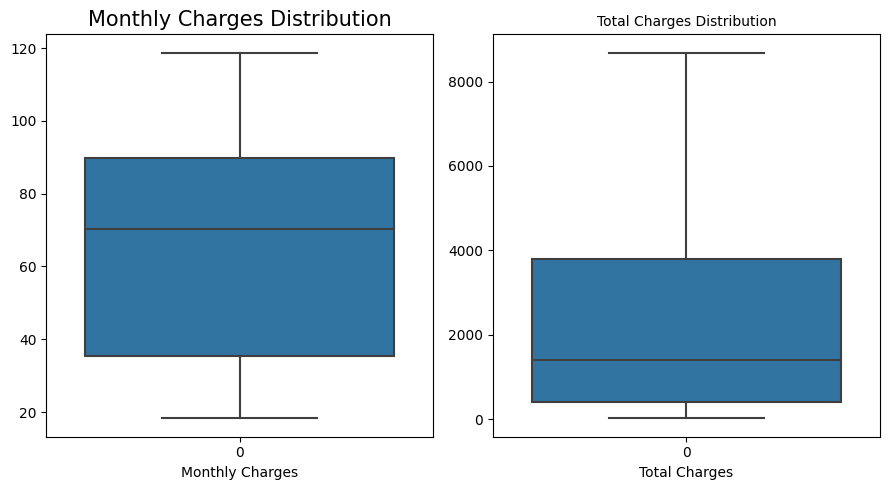

In [10]:
# subplots
fig, axes = plt.subplots(1, 2, figsize=(9, 5))

# Boxplot for Monthly Charges
ax1 = sns.boxplot(data=contract['monthlycharges'], ax=axes[0])
ax1.set_title('Monthly Charges Distribution', fontsize=15)
ax1.set_xlabel('Monthly Charges')

# Clean the 'totalcharges' column
# Replace empty strings with NaN and convert to float
contract['totalcharges'] = contract['totalcharges'].replace('', np.nan)
contract['totalcharges'] = pd.to_numeric(contract['totalcharges'], errors='coerce')

# Drop rows with NaN values in 'totalcharges'
total = contract.dropna(subset=['totalcharges'])

# Boxplot for Total Charges
ax2 = sns.boxplot(data=total['totalcharges'], ax=axes[1])
ax2.set_title('Total Charges Distribution', fontsize=10)
ax2.set_xlabel('Total Charges')

plt.tight_layout()
plt.show()


In [11]:
total[['monthlycharges', 'totalcharges']].describe()

,monthlycharges,totalcharges
count,7032.000000,7032.000000
mean,64.798208,2283.300441
std,30.085974,2266.771362
min,18.250000,18.800000
25%,35.587500,401.450000
50%,70.350000,1397.475000
75%,89.862500,3794.737500
max,118.750000,8684.800000


## Findings
### Monthly Charges

Median is 70.35

Mean is 64.79


### Total Charges

Median is 1397.47

Mean is 2283.30

## Internet EDA

In [12]:
# Internet EDA
list_columns = internet.columns[2:].tolist()

def total_addons(x, list_columns=list_columns):
    num = 0
    for i in list_columns:
        if x[i] == 'Yes':
            num = num+1
            
    return num

In [13]:
internet['total_addons'] = internet.apply(total_addons, axis=1)
internet['total_addons'] = internet['total_addons'].astype('int')

In [14]:
list_value = []
for i in internet.columns[2:-1].tolist():
    value = internet.groupby(i)['customerid'].count()['Yes']
    list_value.append(value)
    
eda_addons = pd.DataFrame(data=list_value, columns=['count'], index=internet.columns[2:-1].tolist()).sort_values(by='count', ascending=False)

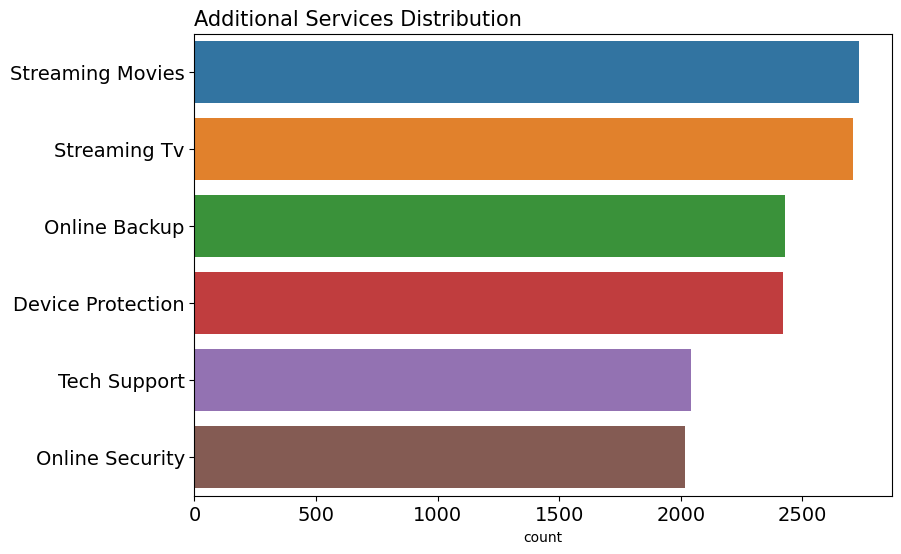

In [15]:
list_ticks = ['Streaming Movies', 'Streaming Tv', 'Online Backup', 'Device Protection', 'Tech Support', 'Online Security']

plt.figure(figsize=(9,6))
ax = sns.barplot(x = 'count', y = eda_addons.index, data = eda_addons)

ax.tick_params(labelsize=14)
ax.set_title('Additional Services Distribution', loc='left', fontsize=15)
ax.set_yticklabels(list_ticks)

plt.show()

## Findings
The most frequently purchased add-ons are Streaming Movies and TV.
The add-ons with the lowest purchase rates are Tech Support and Online Security.

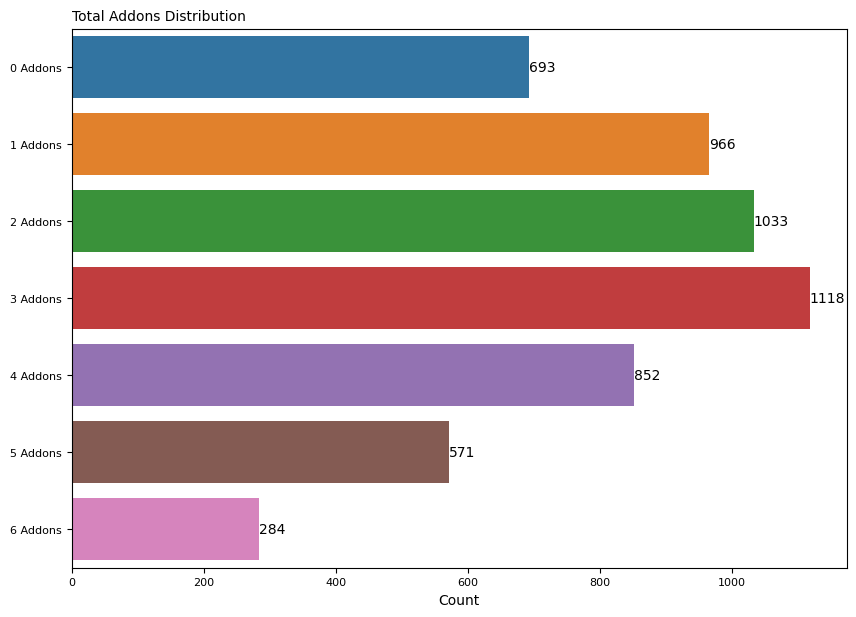

In [16]:
data_addons = internet.total_addons.value_counts().sort_index().rename(index={
    3: '3 Addons',
    2: '2 Addons',
    1: '1 Addons',
    4: '4 Addons',
    0: '0 Addons',
    5: '5 Addons',
    6: '6 Addons'
}).reset_index()

# Create the bar plot
plt.figure(figsize=(10, 7))
ax = sns.barplot(x='total_addons', y='index', data=data_addons)

# labels and title
ax.tick_params(labelsize=8)
ax.set_title('Total Addons Distribution', loc='left', fontsize=10)
ax.set_ylabel('')
ax.set_xlabel('Count')

# bars with the count values
for index, value in enumerate(data_addons['total_addons']):
    ax.text(value, index, f'{value}', va='center', ha='left', fontsize=10)
plt.show()


## Findings
A total of 693 customers opted not to buy any add-ons.
The most common choice among customers is to purchase 3 add-ons, with 1,118 customers selecting this option.
After 3 add-ons, there is a noticeable decline in the number of customers as the number of add-ons increases.

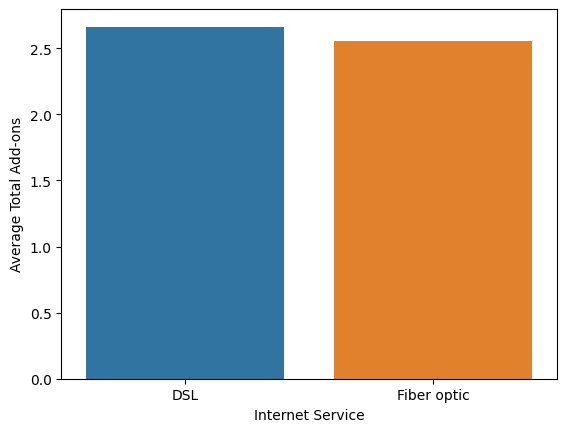

In [17]:
isp = internet.groupby('internetservice')['total_addons'].mean().reset_index()
isp
sns.barplot(x = 'internetservice', y = 'total_addons', data = isp)
plt.xlabel('Internet Service')
plt.ylabel('Average Total Add-ons')

plt.show()

In [18]:
isp = internet.groupby('internetservice')['total_addons'].mean().reset_index()
isp

,internetservice,total_addons
0,DSL,2.662949
1,Fiber optic,2.553618


## Findings
Customers with DSL subscriptions purchase an average of 2.6 add-ons, while those with Fiber Optic subscriptions purchase an average of 2.5 add-ons.
Since these averages are quite close, it suggests that the purchasing behavior of customers in both categories is similar and not significantly different.

## EDA Phone

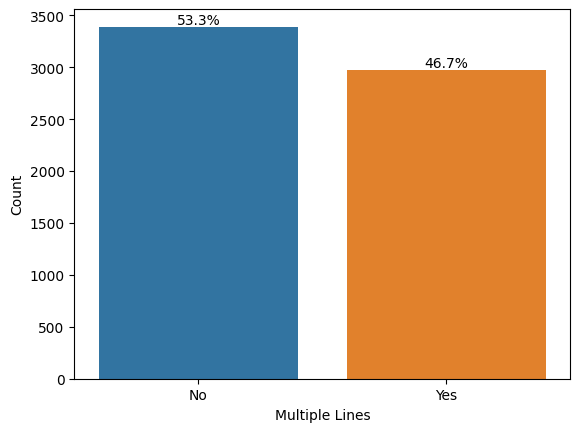

In [19]:
# Group by multiplelines
phone = phone.groupby('multiplelines')['customerid'].count().reset_index()

# Calculate percentages
phone['percentage'] = (phone['customerid'] / phone['customerid'].sum()) * 100

# bar plot
sns.barplot(x='multiplelines', y='customerid', data=phone)
plt.xlabel('Multiple Lines')
plt.ylabel('Count')

# Add percentages on the bars
for index, value in enumerate(phone['percentage']):
    plt.text(index, phone['customerid'].iloc[index], f'{value:.1f}%', ha='center', va='bottom')

# Show the plot
plt.show()


## Findings;  
53.3% of customers who opted for Phone service prefer Non-Multiple Lines, while 46.7% prefer Multiple Lines.

## Customers who are using both services 

In [20]:
len(personal), len(contract), len(internet), len(phone)

(7043, 7043, 5517, 2)

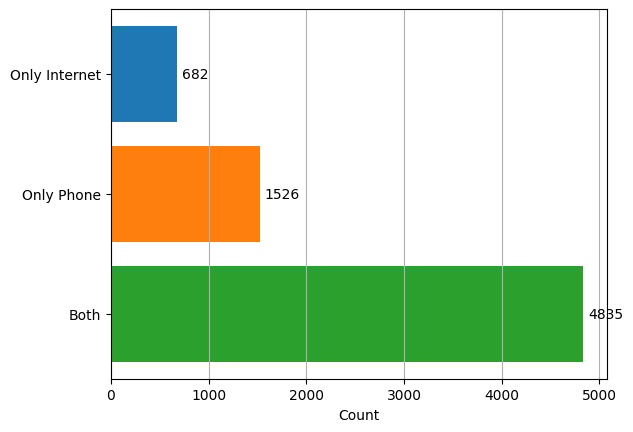

In [21]:
list_category = ['Only Internet', 'Only Phone', 'Both']
list_count = [682, 1526, 4835]

fig, ax = plt.subplots()

y_pos = np.arange(len(list_category))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c'] 

bars = ax.barh(y_pos, list_count, color=colors, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(labels=list_category)
ax.invert_yaxis()
ax.set_xlabel('Count')
plt.grid(axis='x')

# bars with counts
for bar in bars:
    width = bar.get_width()
    ax.text(width + max(list_count)*0.01, bar.get_y() + bar.get_height()/2,
            f'{int(width)}', va='center', fontsize=10)

plt.show()


## Finding 
Most customers subscribe to both internet and phone services. 
There are only 2,208 customers who use either internet or phone service alone.

## Which gender uses yearly contract the most?

In [22]:
gender_type = data.groupby(['gender', 'type']).size().unstack()
# Label the rows and columns
gender_type.index = ['Female', 'Male']
gender_type.columns = ['Month-to-month', 'One year', 'Two year']
print(gender_type)

        Month-to-month  One year  Two year
Female            1925       718       845
Male              1950       755       850


In [23]:
print(data.columns)

Index(['type', 'paperlessbilling', 'paymentmethod', 'monthlycharges',
       'totalcharges', 'gender', 'seniorcitizen', 'partner', 'dependents',
       'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection',
       'techsupport', 'streamingtv', 'streamingmovies', 'multiplelines',
       'churn'],
      dtype='object')


# Modeling and Evaluation
## Logistic Regression

In [24]:
logreg = LogisticRegression(class_weight='balanced', random_state=42)
logreg.fit(X_train, y_train)

y_pred_lr = logreg.predict(X_test)
y_prob_lr = logreg.predict_proba(X_test)[:, 1]

print("Logistic Regression AUC-ROC:", roc_auc_score(y_test, y_prob_lr))
print("Accuracy:", accuracy_score(y_test, y_pred_lr))


Logistic Regression AUC-ROC: 0.8225167273760624
Accuracy: 0.7288857345635202


## Random Forest

In [25]:
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

print("Random Forest AUC-ROC:", roc_auc_score(y_test, y_prob_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))


Random Forest AUC-ROC: 0.82235655790643
Accuracy: 0.7856635911994322


##  LightGBM

In [26]:
# Compute scale_pos_weight
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

lgbm = LGBMClassifier(random_state=42, scale_pos_weight=scale_pos_weight)
lgbm.fit(X_train, y_train)

y_pred_lgb = lgbm.predict(X_test)
y_prob_lgb = lgbm.predict_proba(X_test)[:, 1]

print("LightGBM AUC-ROC:", roc_auc_score(y_test, y_prob_lgb))
print("Accuracy:", accuracy_score(y_test, y_pred_lgb))


LightGBM AUC-ROC: 0.8290332997494122
Accuracy: 0.7572746628814763


## Feature Importance (LGBM & RF)

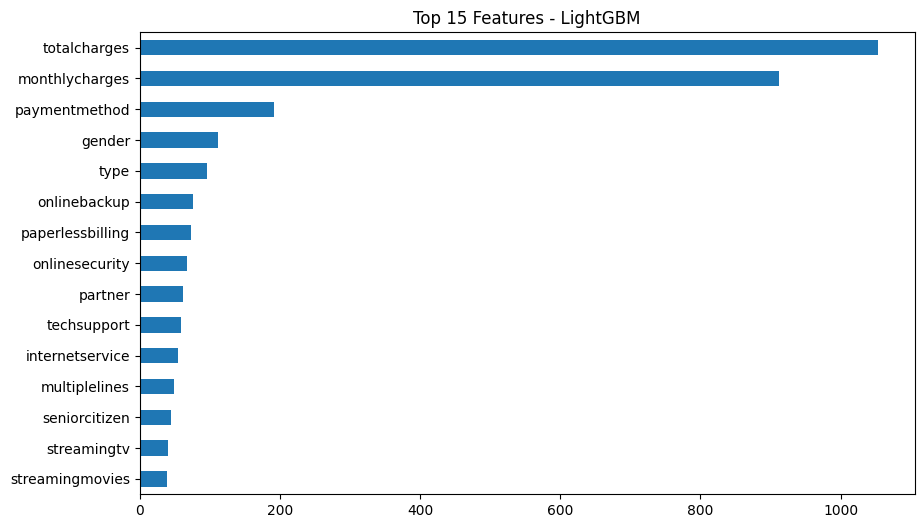

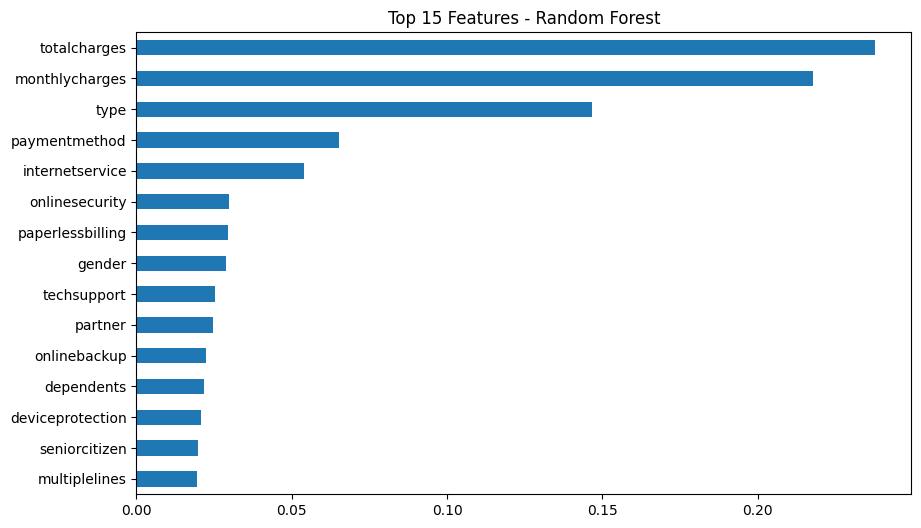

In [27]:
# LightGBM feature importance
lgbm_importance = pd.Series(lgbm.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
lgbm_importance.head(15).plot(kind='barh')
plt.title("Top 15 Features - LightGBM")
plt.gca().invert_yaxis()
plt.show()

# Random Forest feature importance
rf_importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
rf_importance.head(15).plot(kind='barh')
plt.title("Top 15 Features - Random Forest")
plt.gca().invert_yaxis()
plt.show()


## Final Model Comparison

In [28]:
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'LightGBM'],
    'AUC-ROC': [
        roc_auc_score(y_test, y_prob_lr),
        roc_auc_score(y_test, y_prob_rf),
        roc_auc_score(y_test, y_prob_lgb)
    ],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_lgb)
    ]
})

results.sort_values(by='AUC-ROC', ascending=False)


,Model,AUC-ROC,Accuracy
2,LightGBM,0.829033,0.757275
0,Logistic Regression,0.822517,0.728886
1,Random Forest,0.822357,0.785664


## Findings Summary

Best Overall Model (AUC)	LightGBM performs best on AUC-ROC, making it the best model for churn detection, where identifying positives (churners) is critical.

Best Accuracy	Random Forest has the highest accuracy, but this can be misleading in imbalanced datasets.

Logistic Regression	Slightly lower AUC/Accuracy, but interpretable and performs decently. Good as a benchmark.


## Recommendation:
Primary Model: Use LightGBM for churn prediction and business decisions.

Use Logistic Regression to explain features influencing churn.

Random Forest for Best accuracy, consider if false positives have a high cost.